In [360]:
import requests
from io import BytesIO
import BuildGlassesDataset
import matplotlib.pyplot as plt
import tensorflow as tf
import BinaryClassifier
from keras import callbacks
import PIL
import numpy as np
import cv2

In [2]:
# Hyper parameters and constants
positive_directory_path = "C:/Users/allan/Downloads/CelebA/Eyeglasses_dataset/Positive"
negative_directory_path = "C:/Users/allan/Downloads/CelebA/Eyeglasses_dataset/Negative"
target_size = (128, 128)
model_input_shape = (128,128,3)
crop_images = False
batch_size = 64
epochs = 20
train_val_split = 0.95

In [13]:
BuildGlassesDataset = BuildGlassesDataset.BuildGlassesDataset(
    target_size=target_size,
    crop_images=crop_images,
    positive_directory_path=positive_directory_path,
    negative_directory_path=negative_directory_path,
    batch_size=batch_size,
    train_val_split=train_val_split
)

Found 13193 files belonging to 1 classes.
Found 13194 files belonging to 1 classes.


In [14]:
train_dataset, val_dataset = BuildGlassesDataset.get_datasets()

In [15]:
classifier_builder = BinaryClassifier.BinaryClassifier(target_shape=model_input_shape)
classifier_builder.build_model()
classifier_builder.summarize_model()
classifier_builder.compile_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 24)   648         ['input_2[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 64, 24)   96          ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 64, 64, 24)   0           ['stem_bn[0][0]']          

In [16]:
classifier = classifier_builder.get_model()

In [17]:
def validation_callback(epoch, logs=None):
    tf.keras.models.save_model(classifier, f"EyeGlassesModels2/Epoch{epoch+1}.h5")
    pass

my_callback = callbacks.LambdaCallback(on_epoch_end=validation_callback)

In [18]:
classifier.fit(x = train_dataset, epochs = epochs,validation_data = val_dataset, callbacks=[my_callback])

Epoch 1/20
392/392 [==============================] - 179s 354ms/step - loss: 0.6945 - binary_accuracy: 0.6444 - val_loss: 0.6749 - val_binary_accuracy: 0.7644
Epoch 2/20
392/392 [==============================] - 151s 343ms/step - loss: 0.4762 - binary_accuracy: 0.7991 - val_loss: 0.4701 - val_binary_accuracy: 0.8561
Epoch 3/20
392/392 [==============================] - 157s 353ms/step - loss: 0.3610 - binary_accuracy: 0.8576 - val_loss: 0.2754 - val_binary_accuracy: 0.8871
Epoch 4/20
392/392 [==============================] - 159s 355ms/step - loss: 0.2856 - binary_accuracy: 0.8922 - val_loss: 0.2226 - val_binary_accuracy: 0.9098
Epoch 5/20
392/392 [==============================] - 162s 363ms/step - loss: 0.2366 - binary_accuracy: 0.9104 - val_loss: 0.2332 - val_binary_accuracy: 0.9235
Epoch 6/20
392/392 [==============================] - 167s 368ms/step - loss: 0.1982 - binary_accuracy: 0.9257 - val_loss: 0.1396 - val_binary_accuracy: 0.9492
Epoch 7/20
392/392 [====================

In [606]:
model = tf.keras.models.load_model("EyeGlassesModels/Epoch20.h5")

In [607]:
# Saliency map first
# Differentiate the output with respect to the inputs
def get_saliency_map(model, image):
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        pass
    grad = tape.gradient(prediction, image)
    grad = tf.reduce_mean(grad, axis=3)
    return grad, prediction

def get_gradcam_map(image, model, alpha):
    # Prepare the image to be inputted into the model
    image = tf.expand_dims(image, axis = 0)
    # Construct the grad cam model
    grad_cam_model = tf.keras.models.Model(
        inputs = [model.inputs],
        outputs = [
            model.get_layer('top_activation').output,
            model.output
        ]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_cam_model(image)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        print(class_channel)
        pass
    # Differentiate class's output wrt. conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.matmul(last_conv_layer_output, tf.expand_dims(pooled_grads, axis=-1))
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    #Upscale heatmap to image's size
    image = image[0]
    heatmap = np.array(heatmap)

    heatmap = cv2.resize(heatmap, (image.shape[0], image.shape[1]))
    heatmap = tf.cast(heatmap*255, tf.uint8).numpy()
    # Requires input uint8
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = heatmap/255.
    combined_image = image*alpha + heatmap*(1-alpha)
    return combined_image

def overlap_saliency_map(image, map, prediction, imageAlpha):
    plt.imshow(image, alpha=imageAlpha)
    plt.imshow(map, alpha=1-imageAlpha)
    plt.title(prediction)
    plt.show()
    pass


In [608]:
def center_crop(image):
    # Get all dimensions of the image
    shape = image.shape
    dim1 = shape[0]
    dim2 = shape[1]
    # Get the smaller dimension
    min_dim = min(dim1, dim2)
    avg_dim1 = dim1//2
    avg_dim2 = dim2//2
    center_cropped_image = image[avg_dim1-min_dim//2:avg_dim1+min_dim//2,avg_dim2-min_dim//2:avg_dim2+min_dim//2,:]
    return center_cropped_image

In [658]:
image_path = "https://www1.pictures.stylebistro.com/gi/Sylvester+Stallone+Classic+Sunglasses+Aviator+XVUs73OS3L2x.jpg"

(682, 682, 3)


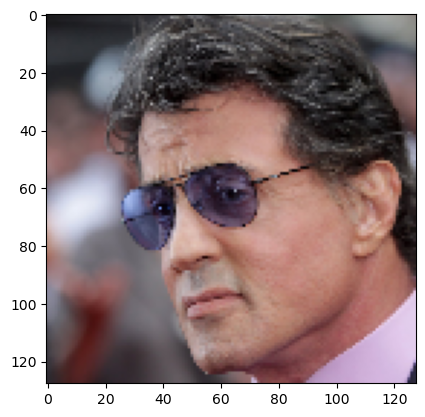

In [659]:
# Loading from url
response = requests.get(image_path)
# Load the image
image = PIL.Image.open(BytesIO(response.content))
# Convert to tensor and scale it
image = np.array(image)/255.
# Ensure there isn't a transparency layer
image = image[:,:,:3]
# aspect ratio 1:1
image = center_crop(image)
print(image.shape)
# Resize
image = cv2.resize(image, dsize=(128,128))
plt.imshow(image)
plt.show()

In [660]:
# Prepare to input it into model
image = tf.expand_dims(image, axis = 0)
print(image.shape)

(1, 128, 128, 3)


In [661]:
saliency_map, prediction = get_saliency_map(model, image)
saliency_map = tf.expand_dims(saliency_map[0], axis = -1)

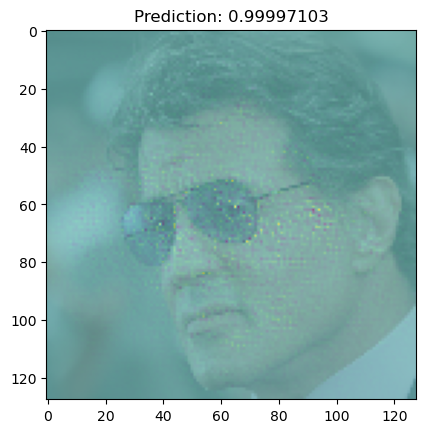

In [662]:
overlap_saliency_map(image=image[0],
                     map=saliency_map,
                     prediction="Prediction: " + str(tf.get_static_value(tf.squeeze(prediction))),
                     imageAlpha=0.5)

In [663]:
# Create a gradcam heat map
heatmap = get_gradcam_map(image=image[0], model=model, alpha=0.5)

tf.Tensor([0.99997103], shape=(1,), dtype=float32)


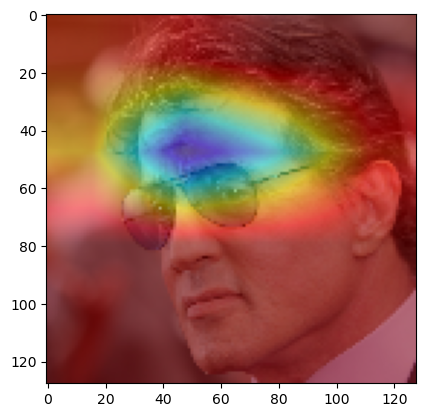

In [664]:
plt.imshow(heatmap)